In [2]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
from threading import Thread
from datetime import timedelta , date
import time

import re
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import os
import glob

from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

In [4]:
scraped_tweets = 0
base_time = time.time()
rate = 1
def scrape_report():   
    global scraped_tweets, base_time, rate, total_tweets

    scraped_tweets += 1

    if scraped_tweets % 10 == 0:
        current_time = time.time()
        elapsed_time = current_time - base_time
        
        if elapsed_time > 0:
            rate = round( 10 / elapsed_time , 2)
            base_time = current_time

    remaining_time = round((((total_tweets - scraped_tweets) / rate) / 60) , 2)

    print('Total tweets = {} \tEstimated remaining time = {} minutes \tRate = {} tweets/sec'
    .format(scraped_tweets, remaining_time , rate) , end="\r")


In [5]:
def popularity(tweet):
    return (tweet.likeCount + tweet.retweetCount +
            tweet.replyCount + tweet.quoteCount)

In [6]:
def get_tweets(max_tweet : int, start_date : str, end_date : str):
    
    tweets_list = []
    user_IDs = []

    query = 'biden -trump since:{} until:{} lang:en -filter:retweets'.format(start_date, end_date)

    accepted_tweets = 0
    for tweet in sntwitter.TwitterSearchScraper(query).get_items():
        
        if accepted_tweets >= max_tweet :
            tweets_df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])
            return tweets_df

        if tweet.user.id not in user_IDs and popularity(tweet) > 20 :
            tweets_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
            accepted_tweets += 1 
            user_IDs.append(tweet.user.id)
            scrape_report()

In [7]:
NO_tweets_in_datasets = 10000
total_datasets = 35
total_tweets = NO_tweets_in_datasets * total_datasets

base_date = date(2021,12,14)
delta_date = timedelta(days = 10)

scraper_args = []

for i in range(total_datasets):

    argument = (NO_tweets_in_datasets, (base_date - delta_date)
    .strftime("%Y-%m-%d"), base_date.strftime("%Y-%m-%d"))
    
    scraper_args.append(argument)
    base_date -= delta_date

In [8]:
class ThreadWithReturnValue(Thread):
    def __init__(self, group=None, target=None, name=None,
                 args=(), kwargs={}, Verbose=None):
        Thread.__init__(self, group, target, name, args, kwargs)
        self._return = None
    def run(self):
        if self._target is not None:
            self._return = self._target(*self._args,
                                                **self._kwargs)
    def join(self, *args):
        Thread.join(self, *args)
        return self._return

In [9]:
df_list = []
threads = []

for i in range(len(scraper_args)):
    twrv = ThreadWithReturnValue(target=get_tweets, args = scraper_args[i])
    threads.append(twrv)

for t in threads:
    t.start()

for t in threads:
    tweet_dataframe = t.join()
    df_list.append(tweet_dataframe)

In [ ]:
for i in range(len(df_list)):
    path=r"C:\Users\pouria\Desktop\project\datasets\\"
    filename = path + (df_list[i]['Datetime'].iloc[[0]]).to_string()[4:14] + '.csv'
    df_list[i].to_csv(filename, sep=',', index=False)

In [ ]:
path = r'C:\Users\pouria\Desktop\project\datasets'
csv_files = glob.glob(os.path.join(path, "*.csv"))

dataFrames = []
for f in csv_files:
	
	df = pd.read_csv(f)
	dataFrames.append(df)

In [ ]:
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
stopwords.remove("not")

def clean_text(tweet : str):

    tweet = tweet.lower()
    tweet = re.sub("@[A-Za-z0-9_]+","", tweet) 
    tweet = re.sub("#[A-Za-z0-9_]+","", tweet)
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE) 

    tweet = nlp(tweet)
    tweet = ' '.join([token.lemma_ for token in tweet]) 
    tweet = ' '.join([word for word in tweet.split() if not word in stopwords])

    return tweet

In [ ]:
sid = SentimentIntensityAnalyzer()

def get_sentiment(tweet : str):
    return sid.polarity_scores(tweet)['compound']

In [ ]:
for i in range(len(dataFrames)):
    dataFrames[i]['Clean text'] = dataFrames[i]['Text'].apply(clean_text)
    dataFrames[i]['Sentiment'] = dataFrames[i]['Clean text'].apply(get_sentiment)
    dataFrames[i]['Clean text'] =  dataFrames[i]['Clean text'].apply(lambda x: re.sub('[^a-z]', ' ', str(x)))
    dataFrames[i].fillna('', inplace=True)

**store processed data in the system**

In [ ]:
for i in range(len(dataFrames)):
    path=r"C:\Users\pouria\Desktop\project\clean-sentiment\\"
    filename = path + (dataFrames[i]['Datetime'].iloc[[0]]).to_string()[5:15] + '.csv'
    dataFrames[i].to_csv(filename, sep=',', index=False)

**read stored data from system**

In [3]:
path = r'C:\Users\pouria\Desktop\project\clean-sentiment'
csv_files = glob.glob(os.path.join(path, "*.csv"))

dataFrames = []
for f in csv_files:
	
	df = pd.read_csv(f)
	dataFrames.append(df)

In [109]:
def remove_unwanted_words(text : str):
    unwanted_words = ['biden', 'joe', 'amp']
    text = ' '.join(word for word in text.split() if not word in unwanted_words)
    return text

In [110]:
def tweets_wordcloud(tweets_text : str):

    tweets_text = remove_unwanted_words(tweets_text)

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 15).generate(tweets_text)
    
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

In [111]:
def most_occured_words(text : str):
    split_it = text.split()
    Counters_found = Counter(split_it)
    most_occur = Counters_found.most_common(100)

    most_accured_list = []
    for word_tuple in most_occur:
        most_accured_list.append(word_tuple[0])

    return most_accured_list

mow = []

In [19]:
text = ''
for i in range(len(dataFrames)):    

    df_month = (dataFrames[i]['Datetime'].iloc[[0]]).to_string()[10:12]
    
    if df_month == '01' or df_month == '02' or df_month == '03':
        for tweet in dataFrames[i]['Clean text']:
            text += " ".join(str(tweet).split())

mow += most_occured_words(text)
tweets_wordcloud(text)

In [21]:
text = ''
for i in range(len(dataFrames)):    

    df_month = (dataFrames[i]['Datetime'].iloc[[0]]).to_string()[10:12]
    
    if df_month == '04' or df_month == '05' or df_month == '06':
        for tweet in dataFrames[i]['Clean text']:
            text += " ".join(str(tweet).split())

mow += most_occured_words(text)
tweets_wordcloud(text)

In [22]:
text = ''
for i in range(len(dataFrames)):    

    df_month = (dataFrames[i]['Datetime'].iloc[[0]]).to_string()[10:12]
    
    if df_month == '07' or df_month == '08' or df_month == '09':
        for tweet in dataFrames[i]['Clean text']:
            text += " ".join(str(tweet).split())

mow += most_occured_words(text)
tweets_wordcloud(text)

In [23]:
text = ''
for i in range(len(dataFrames)):    

    df_month = (dataFrames[i]['Datetime'].iloc[[0]]).to_string()[10:12]
    
    if df_month == '10' or df_month == '11' or df_month == '12':
        for tweet in dataFrames[i]['Clean text']:
            text += " ".join(str(tweet).split())

mow += most_occured_words(text)
tweets_wordcloud(text)

In [ ]:
unique_list = [key for key in Counter(mow).keys() if Counter(mow)[key]==1]
tweets_wordcloud(' '.join([word for word in unique_list])) 

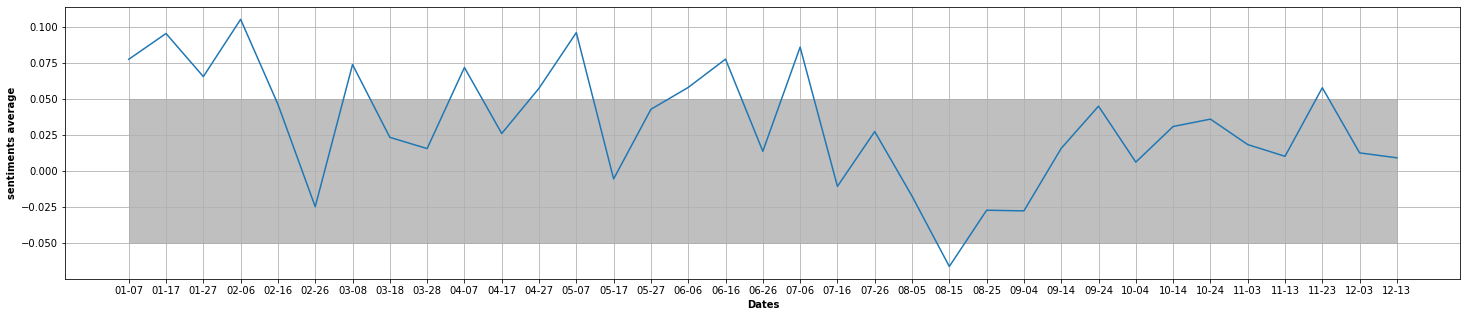

In [45]:
sentiments = []
dates = []
for i in range(len(dataFrames)):
    sentiments.append(round(dataFrames[i]['Sentiment'].mean() , 5))
    dates.append(dataFrames[i]['Datetime'].iloc[0][5:10])

plt.figure(figsize=(25, 5))
plt.plot(dates, sentiments)
plt.xlabel("Dates" , fontweight='bold')
plt.ylabel("sentiments average" , fontweight='bold')
plt.fill_between(dates, -0.05 , 0.05, alpha = 0.5 , color = 'grey')
plt.grid()

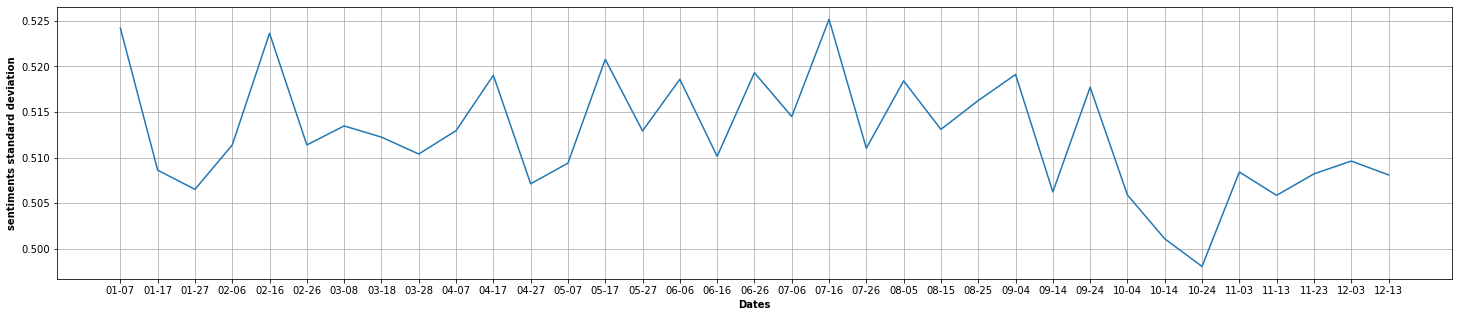

In [50]:
sentiments = []
dates = []
for i in range(len(dataFrames)):
    sentiments.append(round(dataFrames[i]['Sentiment'].std() , 5))
    dates.append(dataFrames[i]['Datetime'].iloc[0][5:10])

plt.figure(figsize=(25, 5))
plt.plot(dates, sentiments)

plt.xlabel("Dates" , fontweight='bold')
plt.ylabel("sentiments standard deviation" , fontweight='bold')

plt.grid()

In [101]:
pos_text = ''
neg_text = ''

for i in range(len(dataFrames)):    
    
    for j in range(len(dataFrames[i])):
        if dataFrames[i].iloc[j]['Sentiment'] > 0.05:
            pos_text += dataFrames[i].iloc[j]['Clean text']
        
        elif dataFrames[i].iloc[j]['Sentiment'] < -0.05:
            neg_text += dataFrames[i].iloc[j]['Clean text']

    break

In [102]:
posetive_words_list = pos_text.split()
negative_words_list = neg_text.split()

for word in posetive_words_list[:]:
        if word in negative_words_list:
            posetive_words_list.remove(word)
            negative_words_list.remove(word)

pos_text = ' '.join([pos_word for pos_word in posetive_words_list])
neg_text = ' '.join([neg_word for neg_word in negative_words_list])

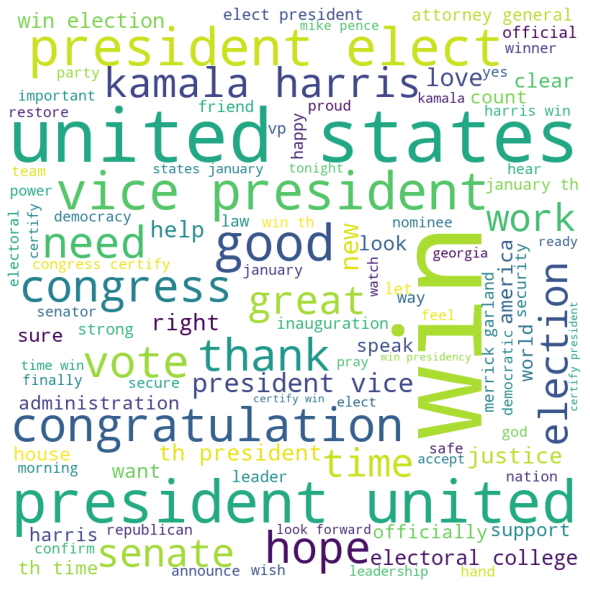

In [112]:
tweets_wordcloud(pos_text)

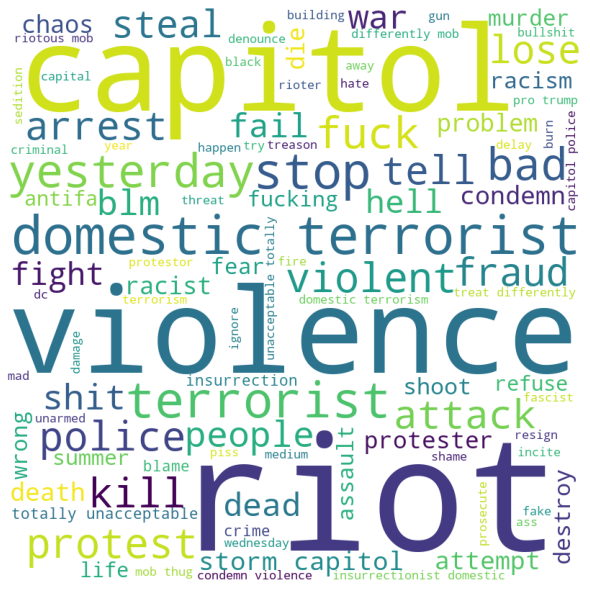

In [113]:
tweets_wordcloud(neg_text)